<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Preprocess-10X" data-toc-modified-id="Preprocess-10X-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess 10X</a></span></li><li><span><a href="#Load-10X" data-toc-modified-id="Load-10X-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load 10X</a></span></li><li><span><a href="#Reduce-dimensions" data-toc-modified-id="Reduce-dimensions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Reduce dimensions</a></span></li><li><span><a href="#Merge-samples" data-toc-modified-id="Merge-samples-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Merge samples</a></span></li><li><span><a href="#Load-gene-markers" data-toc-modified-id="Load-gene-markers-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Load gene markers</a></span></li><li><span><a href="#Get-gene-markers-from-cell-type" data-toc-modified-id="Get-gene-markers-from-cell-type-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Get gene markers from cell type</a></span></li><li><span><a href="#Plot-gene-markers" data-toc-modified-id="Plot-gene-markers-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Plot gene markers</a></span></li><li><span><a href="#Differential-Expression-of-clusters" data-toc-modified-id="Differential-Expression-of-clusters-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Differential Expression of clusters</a></span></li><li><span><a href="#Differential-expression-multiple-clusters" data-toc-modified-id="Differential-expression-multiple-clusters-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Differential expression multiple clusters</a></span></li><li><span><a href="#Differential-expression-one-target-to-many" data-toc-modified-id="Differential-expression-one-target-to-many-2.10"><span class="toc-item-num">2.10&nbsp;&nbsp;</span>Differential expression one target to many</a></span></li><li><span><a href="#Single-Cell-Aggregate" data-toc-modified-id="Single-Cell-Aggregate-2.11"><span class="toc-item-num">2.11&nbsp;&nbsp;</span>Single Cell Aggregate</a></span></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Load-data-and-preprocess" data-toc-modified-id="Load-data-and-preprocess-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load data and preprocess</a></span></li><li><span><a href="#Create-metadata" data-toc-modified-id="Create-metadata-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Create metadata</a></span></li><li><span><a href="#Load-gene-markers-to-dataframe" data-toc-modified-id="Load-gene-markers-to-dataframe-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Load gene markers to dataframe</a></span></li><li><span><a href="#Reduce-dimensions" data-toc-modified-id="Reduce-dimensions-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Reduce dimensions</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Obtain-PCA-and-singular-values" data-toc-modified-id="Obtain-PCA-and-singular-values-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Obtain PCA and singular values</a></span></li><li><span><a href="#Obtain-phate-data" data-toc-modified-id="Obtain-phate-data-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Obtain phate data</a></span></li><li><span><a href="#Obtain-UMAP-data" data-toc-modified-id="Obtain-UMAP-data-3.5.3"><span class="toc-item-num">3.5.3&nbsp;&nbsp;</span>Obtain UMAP data</a></span></li><li><span><a href="#Display-UMAP-for-all-samples" data-toc-modified-id="Display-UMAP-for-all-samples-3.5.4"><span class="toc-item-num">3.5.4&nbsp;&nbsp;</span>Display UMAP for all samples</a></span></li><li><span><a href="#Display-PHATE-for-all-samples" data-toc-modified-id="Display-PHATE-for-all-samples-3.5.5"><span class="toc-item-num">3.5.5&nbsp;&nbsp;</span>Display PHATE for all samples</a></span></li><li><span><a href="#Obtain-clusters-from-UMAP-data" data-toc-modified-id="Obtain-clusters-from-UMAP-data-3.5.6"><span class="toc-item-num">3.5.6&nbsp;&nbsp;</span>Obtain clusters from UMAP data</a></span></li><li><span><a href="#Plot-all-clusters" data-toc-modified-id="Plot-all-clusters-3.5.7"><span class="toc-item-num">3.5.7&nbsp;&nbsp;</span>Plot all clusters</a></span></li><li><span><a href="#Obtain-gene-markers" data-toc-modified-id="Obtain-gene-markers-3.5.8"><span class="toc-item-num">3.5.8&nbsp;&nbsp;</span>Obtain gene markers</a></span></li><li><span><a href="#Plot-genes-on-UMAP" data-toc-modified-id="Plot-genes-on-UMAP-3.5.9"><span class="toc-item-num">3.5.9&nbsp;&nbsp;</span>Plot genes on UMAP</a></span></li></ul></li><li><span><a href="#Differential-expression" data-toc-modified-id="Differential-expression-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Differential expression</a></span><ul class="toc-item"><li><span><a href="#Create-sparse-dataframe" data-toc-modified-id="Create-sparse-dataframe-3.6.1"><span class="toc-item-num">3.6.1&nbsp;&nbsp;</span>Create sparse dataframe</a></span></li><li><span><a href="#Create-differential-expression-dataframe-for-all-clusters" data-toc-modified-id="Create-differential-expression-dataframe-for-all-clusters-3.6.2"><span class="toc-item-num">3.6.2&nbsp;&nbsp;</span>Create differential expression dataframe for all clusters</a></span></li></ul></li></ul></li></ul></div>

# Imports

In [1]:
# !pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn
# !pip install git+https://github.com/jacoblevine/phenograph.git
# !pip install jupyter_contrib_nbextensions


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

from sklearn.decomposition import PCA


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.


# Functions

## Preprocess 10X

In [3]:
def preprocess_10X(data, name='10X-project', percent_mt=20, max_features=5000, min_features=200):
    """This function takes a data-frame (genes x cells), 
    creates a Scprep object with it and filters the object for default tags such as  
    Min and max nFeature_RNA and % of MT

    Parameters:
    @param data data-frame
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Preprocessed Dataframe
    """
    #Remove empty cells and empty genes
    data = scprep.filter.filter_empty_cells(data)
    data = scprep.filter.filter_empty_genes(data)
    
    #Remove elements based on mythocondrial percentage
    mt_genes = scprep.select.get_gene_set(data, starts_with=["MT-", "mt-"])
    data = scprep.filter.filter_gene_set_expression(data=data, genes=mt_genes, percentile=100-percent_mt, keep_cells='below')
    
    #Remove elements based on number of cell and number of features
    data = scprep.filter.filter_library_size(data=data, cutoff=(min_features, max_features), keep_cells='between')
    data = scprep.filter.filter_rare_genes(data=data, cutoff=0, min_cells=3)

    return data

## Load 10X

In [4]:

def load_10X(dir_path, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    """This function takes the path to a 10X output folder and instanciates the Scprep object
    
    Parameters:
    @param file string (path to file)
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Preprocessed DataFrame
    """
    data = scprep.io.load_10X(dir_path, sparse=True, gene_labels='both')
    return preprocess_10X(data=data, percent_mt=percent_mt, max_features=max_features, min_features=min_features)


## Reduce dimensions

In [5]:
def reduce_dim(data, ndims=15, res=.1):
    """This function reduces the dimensions of the Normalized Seurat object
    Runs PCA and then UMAP and then performs clustering

    Parameters:
    @param data DataFrame
    @param ndims integer [3-100]
    @param res double [0-3]
    
    Returns:
    @return Seurat object with reduction embeddings
    """
    
    data = scprep.normalize.library_size_normalize(data)
    data = scprep.utils.matrix_transform(data, np.sqrt)


    return data

## Merge samples

In [6]:
def merge_samples(dir_paths, labels, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    """This function allows to instantiate a merged Seurat object of several distinct samples
    
    Parameters:
    @param files character vector of the files to merge 
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Merged DDataFrame 
    """
    # Declare empty array T
    T=[]
    
    #Loading all files
    for dp in dir_paths:
        T.append(scprep.io.load_10X(dp, sparse=True, gene_labels='both'))
        
    #Merge samples
    data, sample_labels = scprep.utils.combine_batches(
        data=T,
        batch_labels=labels,
        append_to_cell_names=True
    )
    
    # Delete T to save space
    for t in T:
        del t

    return preprocess_10X(data, name, percent_mt, max_features, min_features), sample_labels

## Load gene markers

In [7]:


def load_gene_markers(file_path, file_seperator):
    """This function takes the path to tsv file (typically from panglaodb)
    outputs a dataframe of the loaded data
    
    Parameters:
    @param file string (path to file)
    @param file seperator (ex: '\t' for tsv)
    
    Returns:
    @returns load panda DataFrame
    """
    
    return pd.read_csv(file_path, file_seperator)

## Get gene markers from cell type

In [8]:
def get_cell_type_markers(marker_dataframe, cell_type):
    """This function takes a cell type, and returns all associated markers (in title form)
    
    Parameters:
    @param target dataframe
    @param cell type (exact string)
    
    Returns:
    @returns array of marker strings
    """
    
    cell_type_subset_df = marker_dataframe[marker_dataframe["cell type"] == cell_type]
    markers =cell_type_subset_df["official gene symbol"].tolist()
    m_lower_case = [m.lower() for m in markers]
    return [m.capitalize() for m in m_lower_case]

## Plot gene markers

In [9]:
def plot_gene_markers(data, reduced_data, gene_markers, reduced_data_method, figsize=(14,98)):
    """
    This function identifies specific genes on a plot. It is meant to identify the appropriate clusters
    
    Parameters:
    @param input data
    @param gene_marker list
    @param data_type (string of data type)
    
    Returns:
    @returns a plot 
    """
    n_cols = 2
    n_rows = math.ceil(len(gene_markers)/2)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for curr_gene, ax in zip(gene_markers, axes.flatten()):

        # What cells contain an expression of this gene?
        try:
            expression = scprep.select.select_cols(data, exact_word=curr_gene)

            sort_index = expression.sort_values().index

            scprep.plot.scatter2d(reduced_data.loc[sort_index], 
                                  c=np.where(expression.loc[sort_index]>=10, '10+', expression.loc[sort_index]), 
                                  shuffle=False,
                                  title=curr_gene, 
                                  ticks=None, 
                                  label_prefix=reduced_data_method, 
                                  ax=ax)
        except:
            print("Gene {} is not in samples".format(curr_gene))
    fig.tight_layout()

# np.set_printoptions(threshold=np.inf)
# data.columns.values

## Differential Expression of clusters

In [10]:
def diff_exp_clusters(target_clusters, diff_clusters, clusters, data, test_type="ttest", direction="both"):
    """This function takes specific clusters as parameters, and returns their differential expression.
    It is usefull to find elements expressed in one cluster, but not the other
    
    Parameters:
    @param target cluster names list
    @param differential cluster names list
    @param clusters array or dataframe
    @param data
    @param test type string
    @param direction string
    
    Returns:
    @ Returns Dataframe of differentially expressed clusters

    """
    with tasklogger.log_task("diff_exp_clusters"):
        with tasklogger.log_task("Target clusters"):
            data_curr_clusters = pd.DataFrame()
            for cc in target_clusters:
                data_curr = data[clusters == cc]
                data_curr_clusters = pd.concat([data_curr, data_curr_clusters], axis = 0)
        
        with tasklogger.log_task("Diff clusters"):
            data_diff_clusters = pd.DataFrame()
            for dc in diff_clusters:
                data_diff = data[clusters == dc]
                data_diff_clusters=pd.concat([data_diff, data_diff_clusters], axis = 0)

        with tasklogger.log_task("T-test results"):
            result = scprep.stats.differential_expression(X=data_curr_clusters, 
                                                          Y=data_diff_clusters,
                                                          measure=test_type,
                                                          direction=direction)
    return result

## Differential expression multiple clusters

In [11]:
def diff_exp_mul_clusters(target_clusters, clusters, data, test_type="ttest", direction="both"):
    """This function takes specific clusters as parameters, and returns their differential expression as a table
    for each diff cluster.
    
    As this function compares all columns, this is not to be used on SICK vs HEALTHY datasets, as we do not wish to compare 2
    sick datasets
    
    Parameters:
    @param target clusters that we wish to depict in dataframe
    @param clusters array or dataframe
    @param data
    @param test type string
    @param direction string
    
    Returns:
    @ Returns Dataframe of differentially expressed clusters

    """
    with tasklogger.log_task("diff_exp__mul_clusters"):
        result_df = pd.DataFrame()
        for tc in target_clusters:
            with tasklogger.log_task("cluster {}".format(tc)):
                result = scprep.stats.differential_expression(X=data[clusters == tc], 
                                                              Y=data[clusters != tc],
                                                              measure=test_type,
                                                              direction=direction)
                result = result.drop('rank', axis=1)
                result =  result.rename(columns={'difference': tc})

                result_df = pd.concat([result_df, result], axis = 1)

    return result_df

## Differential expression one target to many

In [12]:
def diff_exp_one_target_to_many(target_subset, diff_subsets, clusters, data, test_type="ttest", direction="both"):
    """This function takes specific clusters as parameters, and returns their differential expression as a table
    for each diff cluster.
    
    The column for the target subset contains the diff expression of that subset vs all other subsets combined.
    The remaining columns are the comparison of the target subset with that subset.
    
    This function is made with binary comparison between affected subjects and healthy subjects (Ex: EAE vs WT)
    
    Parameters:
    @param target subset to study
    @param diff subsets elements to compare to our taget
    @param clusters array or dataframe
    @param data
    @param test type string
    @param direction string
    
    Returns:
    @ Returns Dataframe of differentially expressed clusters

    """
    with tasklogger.log_task("diff_exp_target_diffs"):
        result_df = pd.DataFrame()
        with tasklogger.log_task("Target vs everyone"):
            result = scprep.stats.differential_expression(X=data[clusters == target_subset], 
                                                              Y=data[clusters != target_subset],
                                                              measure=test_type,
                                                              direction=direction)
            result = result.drop('rank', axis=1)
            result =  result.rename(columns={'difference': target_subset})

            result_df = pd.concat([result_df, result], axis = 1)
        
        with tasklogger.log_task("Target vs specific subset"):
            for ds in diff_subsets:
                with tasklogger.log_task("cluster {}".format(ds)):
                    result = scprep.stats.differential_expression(X=data[clusters == target_subset], 
                                                                  Y=data[clusters == ds],
                                                                  measure=test_type,
                                                                  direction=direction)
                    result = result.drop('rank', axis=1)
                    result =  result.rename(columns={'difference': ds})

                    result_df = pd.concat([result_df, result], axis = 1)

    return result_df

## Single Cell Aggregate

In [167]:
def sc_aggregate(metadata, cluster_param, target_param, order_by):
    """ Aggregate clusters of celltypes and extract proportion of a group
     
     
    @param metadata Target metadata dataframe
    @param cluster_param Str parameter identifying clusters
    @param target_param Str Name of the metadata feature to aggregate
    @param order_by Str name of the metadata feature to order by
    @return DataFrame with different_columns of percentages
    @return Plot of percentages
    """
    keys = metadata[target_param].value_counts().keys()
    perc_keys = [x+'_perc' for x in keys]
    df=pd.DataFrame(columns=perc_keys)
    df['tot_value'] = 0

    for c in sorted(metadata[cluster_param].unique()):
        subset = metadata[metadata[cluster_param]==c]
        subset_val=subset[target_param].value_counts().to_dict()
        tot_value = subset[target_param].value_counts().sum()

        [subset_val.setdefault(k, 0) for k in keys]
        return_values = [round(subset_val[p]/tot_value*100,2)for p in subset_val]
        
        return_values.append(tot_value)

        df.loc[c] = return_values
        
    df = df.sort_values(by=order_by+'_perc', ascending=False)
    
    axis = df[[x+'_perc' for x in keys]].plot(kind="bar", stacked=True)
#     fig = axis.get_fig ure()
    
    return df, axis

# Main

## Load data and preprocess

In [14]:

dir_paths = [
    "../data/olivier_trial_data/14_EAE_all_cells.MPS12344479-A02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix",
    "../data/olivier_trial_data/15_EAE_all_cells.MPS12344479-B02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix",
    "../data/olivier_trial_data/16_WT_all_cells.MPS12344479-H01.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix"
]

lables = [
    "14_EAE", 
    "15_EAE", 
    "16_WT"
]

data,sample_labels = merge_samples(dir_paths=dir_paths, labels=lables, percent_mt=20, max_features=5000, min_features=200)

# seurat_path = "../../tutorials/seurat_guidedClustering/seurat_clusteringTutorial/filtered_gene_bc_matrices/hg19"
# data = load_10X(dir_path=seurat_path, percent_mt=20, max_features=5000, min_features=200)
data.head()


,0610005C13Rik (ENSMUSG00000109644),0610009B22Rik (ENSMUSG00000007777),0610009O20Rik (ENSMUSG00000024442),0610010F05Rik (ENSMUSG00000042208),0610010K14Rik (ENSMUSG00000020831),0610012G03Rik (ENSMUSG00000107002),0610025J13Rik (ENSMUSG00000046683),0610030E20Rik (ENSMUSG00000058706),0610037L13Rik (ENSMUSG00000028608),0610038B21Rik (ENSMUSG00000097882),...,mt-Co2 (ENSMUSG00000064354),mt-Co3 (ENSMUSG00000064358),mt-Cytb (ENSMUSG00000064370),mt-Nd1 (ENSMUSG00000064341),mt-Nd2 (ENSMUSG00000064345),mt-Nd3 (ENSMUSG00000064360),mt-Nd4 (ENSMUSG00000064363),mt-Nd4l (ENSMUSG00000065947),mt-Nd5 (ENSMUSG00000064367),mt-Nd6 (ENSMUSG00000064368)
AAACCTGGTATCGCAT-1_14_EAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,9.0,5.0,2.0,2.0,1.0,1.0,8.0,0.0,0.0
AAACGGGAGAACTGTA-1_14_EAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,6.0,6.0,3.0,0.0,1.0,4.0,1.0,0.0
AAACGGGGTTCTCATT-1_14_EAE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,9.0,8.0,4.0,6.0,1.0,3.0,17.0,0.0,1.0
AAACGGGGTTCTGAAC-1_14_EAE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13.0,15.0,10.0,3.0,6.0,0.0,4.0,18.0,2.0,0.0
AAAGATGCAATGACCT-1_14_EAE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,26.0,12.0,20.0,6.0,5.0,1.0,2.0,18.0,3.0,1.0


## Create metadata

In [15]:
sample_labels = pd.Series(sample_labels, index=data.index, name = "sample_labels")

libsize = scprep.measure.library_size(data)
libsize.name='library_size'

metadata = pd.concat([sample_labels, libsize], axis=1)


metadata


,sample_labels,library_size
AAACCTGGTATCGCAT-1_14_EAE,14_EAE,2460.0
AAACGGGAGAACTGTA-1_14_EAE,14_EAE,1154.0
AAACGGGGTTCTCATT-1_14_EAE,14_EAE,3949.0
AAACGGGGTTCTGAAC-1_14_EAE,14_EAE,4312.0
AAAGATGCAATGACCT-1_14_EAE,14_EAE,4120.0
...,...,...
TTTGTCACACGACGAA-1_16_WT,16_WT,4019.0
TTTGTCAGTGGCGAAT-1_16_WT,16_WT,2084.0
TTTGTCATCAGTTAGC-1_16_WT,16_WT,3603.0
TTTGTCATCATATCGG-1_16_WT,16_WT,2399.0


## Load gene markers to dataframe

In [16]:
gene_markers = load_gene_markers("../data/gene_bank/PanglaoDB_markers_27_Mar_2020.tsv", "\t")

## Reduce dimensions

In [17]:
reduce_dim(data)

,0610005C13Rik (ENSMUSG00000109644),0610009B22Rik (ENSMUSG00000007777),0610009O20Rik (ENSMUSG00000024442),0610010F05Rik (ENSMUSG00000042208),0610010K14Rik (ENSMUSG00000020831),0610012G03Rik (ENSMUSG00000107002),0610025J13Rik (ENSMUSG00000046683),0610030E20Rik (ENSMUSG00000058706),0610037L13Rik (ENSMUSG00000028608),0610038B21Rik (ENSMUSG00000097882),...,mt-Co2 (ENSMUSG00000064354),mt-Co3 (ENSMUSG00000064358),mt-Cytb (ENSMUSG00000064370),mt-Nd1 (ENSMUSG00000064341),mt-Nd2 (ENSMUSG00000064345),mt-Nd3 (ENSMUSG00000064360),mt-Nd4 (ENSMUSG00000064363),mt-Nd4l (ENSMUSG00000065947),mt-Nd5 (ENSMUSG00000064367),mt-Nd6 (ENSMUSG00000064368)
AAACCTGGTATCGCAT-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,3.492151,6.048584,4.508348,2.851330,2.851330,2.016195,2.016195,5.702659,0.000000,0.000000
AAACGGGAGAACTGTA-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,5.887448,6.582367,7.210622,7.210622,5.098680,0.000000,2.943724,5.887448,2.943724,0.000000
AAACGGGGTTCTCATT-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,1.591316,0.0,0.000000,0.0,0.0,...,4.210226,4.773948,4.500921,3.182632,3.897912,1.591316,2.756240,6.561164,0.000000,1.591316
AAACGGGGTTCTGAAC-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,1.522862,0.0,0.000000,0.0,0.0,...,5.490758,5.898020,4.815713,2.637675,3.730235,0.000000,3.045725,6.460957,2.153652,0.000000
AAAGATGCAATGACCT-1_14_EAE,0.0,0.00000,0.0,0.0,1.557942,0.000000,0.0,1.557942,0.0,0.0,...,7.943979,5.396871,6.967330,3.816164,3.483665,1.557942,2.203263,6.609790,2.698435,1.557942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACACGACGAA-1_16_WT,0.0,0.00000,0.0,0.0,1.577397,1.577397,0.0,0.000000,0.0,0.0,...,3.527167,1.577397,3.863818,1.577397,1.577397,0.000000,0.000000,4.173400,2.230776,0.000000
TTTGTCAGTGGCGAAT-1_16_WT,0.0,2.19054,0.0,0.0,0.000000,3.794126,0.0,0.000000,0.0,0.0,...,4.898196,3.794126,3.097891,2.190540,0.000000,0.000000,2.190540,3.794126,2.190540,2.190540
TTTGTCATCAGTTAGC-1_16_WT,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,3.725228,4.407749,2.885549,1.665973,0.000000,0.000000,0.000000,2.885549,1.665973,0.000000
TTTGTCATCATATCGG-1_16_WT,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,4.565306,4.565306,6.125001,5.401743,5.001042,0.000000,0.000000,6.771443,2.041667,2.041667


## Clustering

### Obtain PCA and singular values

In [18]:
with tasklogger.log_task("PCA"):
    data_pca, singular_values = scprep.reduce.pca(data, n_components=100, return_singular_values=True, method='dense')
    data_pca = pd.DataFrame(data_pca, index=data.index)

Calculating PCA...
Calculated PCA in 18.11 seconds.


### Obtain phate data

In [19]:
# Obtain phate data
data_phate = phate.PHATE().fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 9613 observations and 17684 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 19.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 14.23 seconds.
    Calculating affinities...
    Calculated affinities in 0.21 seconds.
  Calculated graph and diffusion operator in 34.33 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.24 seconds.
    Calculating KMeans...
    Calculated KMeans in 24.71 seconds.
  Calculated landmark operator in 27.35 seconds.
  Calculating optimal t...
    Automatically selected t = 40
  Calculated optimal t in 4.91 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.33 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.74 seconds.
Calculated PHATE in 75.68 seconds.


### Obtain UMAP data

In [20]:
with tasklogger.log_task("UMAP"):
    data_umap = umap.UMAP().fit_transform(data)
    data_umap = pd.DataFrame(data_umap, index=data.index)

Calculating UMAP...
Calculated UMAP in 356.07 seconds.


### Display UMAP for all samples

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

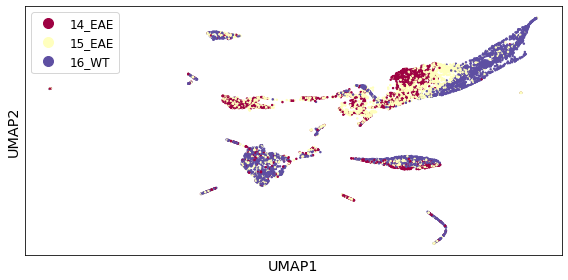

In [21]:
scprep.plot.scatter2d(data_umap, c=metadata['sample_labels'], figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="UMAP")

### Display PHATE for all samples

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

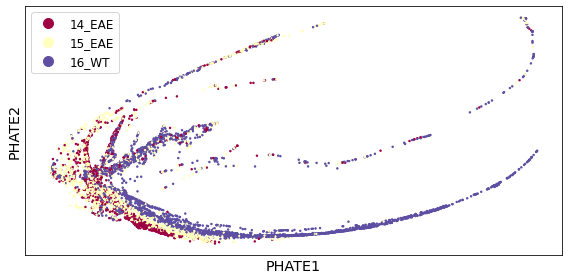

In [22]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

### Obtain clusters from UMAP data

In [23]:
kmeans_clusters = sklearn.cluster.KMeans(n_clusters=20).fit_predict(data_umap)

### Plot all clusters

<AxesSubplot:title={'center':'Clusters according to umap'}, xlabel='0', ylabel='1'>

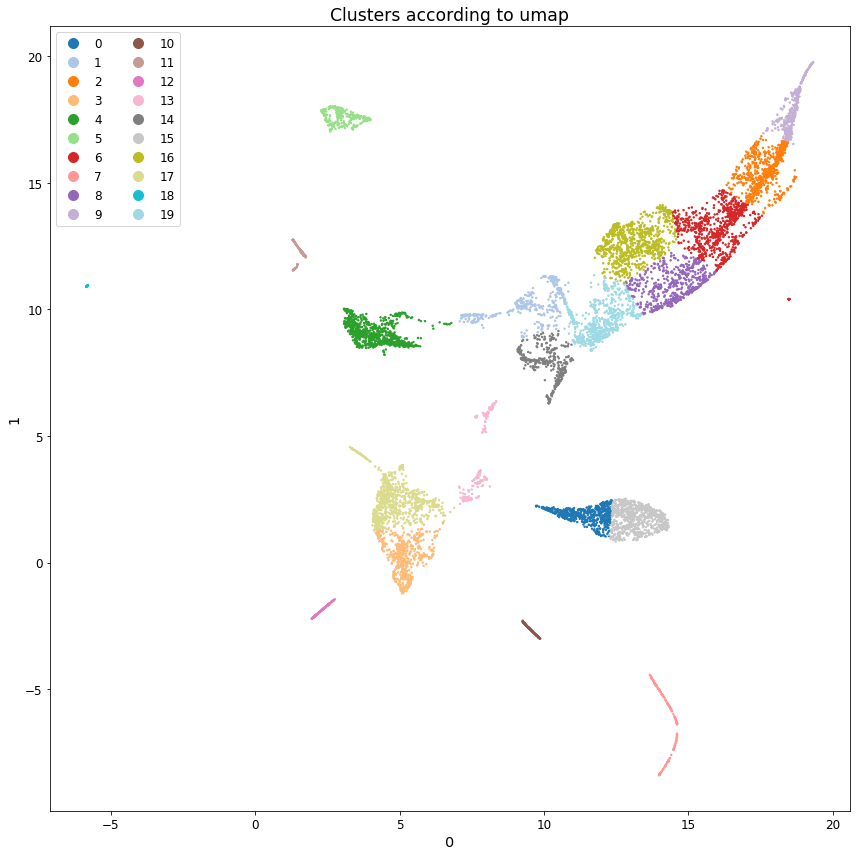

In [24]:
scprep.plot.scatter2d(data_umap, c=kmeans_clusters,figsize=(12, 12),  title="Clusters according to umap")

### Obtain gene markers

In [25]:
choroid_genes = get_cell_type_markers(gene_markers, "Choroid plexus cells")
ependymal_genes = get_cell_type_markers(gene_markers, "Ependymal cells")

### Plot genes on UMAP

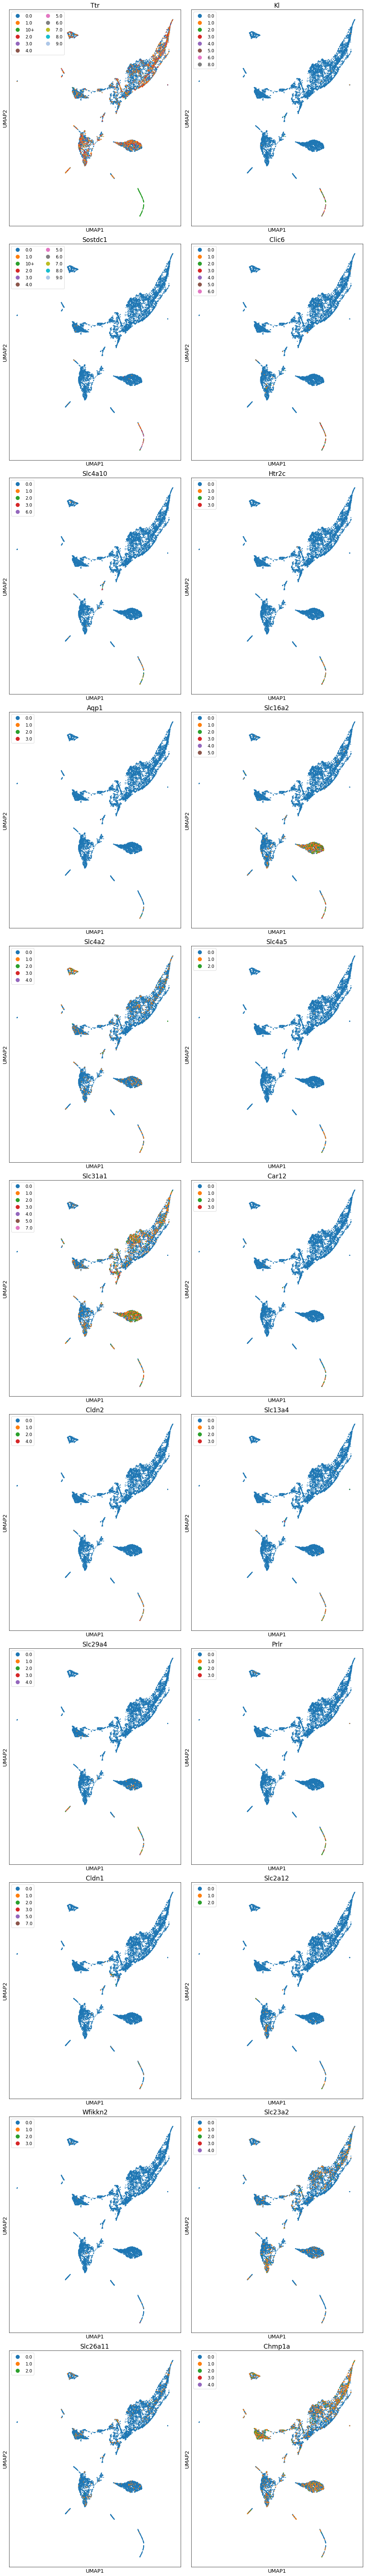

In [26]:
plot_gene_markers(data=data, 
                  reduced_data=data_umap, 
                  gene_markers=choroid_genes, 
                  reduced_data_method="UMAP", 
                  figsize=(14,98))

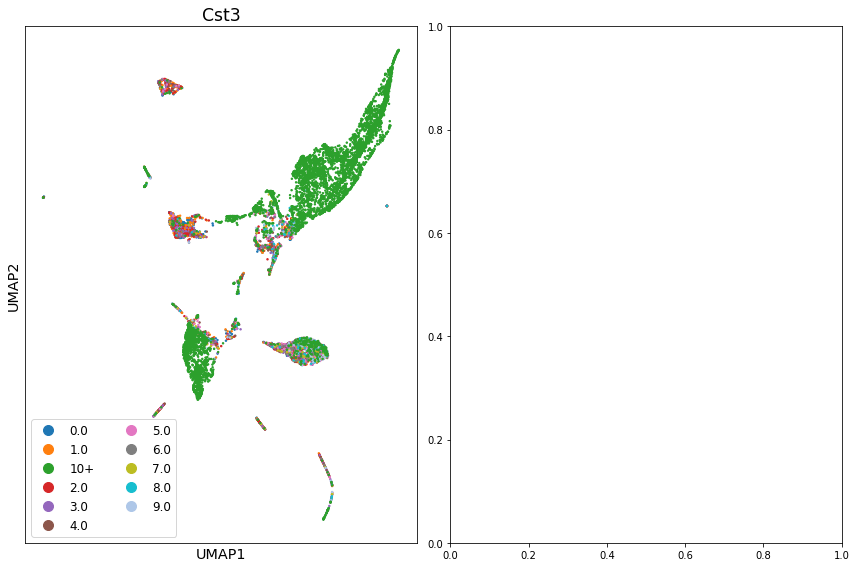

In [27]:
plot_gene_markers(data=data, 
                  reduced_data=data_umap, 
                  gene_markers=['Cst3'], 
                  reduced_data_method="UMAP", 
                  figsize=(12,8))

In [28]:
# Assign cluster number to each cell

kmeans_umap_clusters = pd.Series(kmeans_clusters, index=data.index, name = "kmeans_umap_clusters")
metadata = pd.concat([metadata, kmeans_umap_clusters], axis=1)

metadata

,sample_labels,library_size,kmeans_umap_clusters
AAACCTGGTATCGCAT-1_14_EAE,14_EAE,2460.0,0
AAACGGGAGAACTGTA-1_14_EAE,14_EAE,1154.0,0
AAACGGGGTTCTCATT-1_14_EAE,14_EAE,3949.0,16
AAACGGGGTTCTGAAC-1_14_EAE,14_EAE,4312.0,16
AAAGATGCAATGACCT-1_14_EAE,14_EAE,4120.0,4
...,...,...,...
TTTGTCACACGACGAA-1_16_WT,16_WT,4019.0,2
TTTGTCAGTGGCGAAT-1_16_WT,16_WT,2084.0,7
TTTGTCATCAGTTAGC-1_16_WT,16_WT,3603.0,6
TTTGTCATCATATCGG-1_16_WT,16_WT,2399.0,2


In [29]:
# Extracting appropriate subset

choroid_cell_cluster = 6
data_choroid = data[metadata["kmeans_umap_clusters"] == choroid_cell_cluster]


,16_WT_perc,15_EAE_perc,14_EAE_perc,tot_value
9,96.70,3.30,0.00,424.0
2,91.32,8.39,0.28,703.0
6,74.46,25.28,0.25,791.0
14,71.28,27.18,1.54,390.0
10,70.42,28.17,1.41,142.0
3,70.09,21.88,8.03,585.0
17,68.45,19.09,12.46,859.0
7,65.28,19.69,15.03,193.0
11,62.77,20.44,16.79,137.0
8,61.55,33.45,5.00,580.0


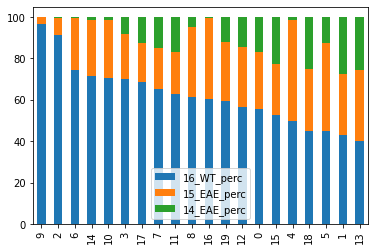

In [166]:
# sc_aggregate_test = pd.DataFrame(columns=["spec_amnt_exp",
#                                           "spec_amnt_tot", 
#                                           "data_amnt_exp", 
#                                           "data_amnt_tot", 
#                                           "data_perc_exp", 
#                                           "data_perc_tot"])

# for i in range(1,10):
#     with tasklogger.log_task("values cluster {}".format(i)):
#         data_cluster = data[metadata["kmeans_umap_clusters"] == i]
#         characteristic_subset = scprep.select.select_cols(data, exact_word=choroid_genes)
#         spec_amnt_exp = data_cluster.astype(bool).to_numpy().sum()
#         spec_amnt_tot = data_cluster.to_numpy().sum()
#         data_amnt_exp = data.astype(bool).to_numpy().sum()
#         data_amnt_tot = data.to_numpy().sum()
#         data_perc_exp = spec_amnt_exp / data_amnt_exp
#         data_perc_tot = spec_amnt_tot / data_amnt_tot

#         sc_aggregate_test.loc[i] = [spec_amnt_exp, spec_amnt_tot, data_amnt_exp, data_amnt_tot, data_perc_exp, data_perc_tot]
    
# # choroid_columns = scprep.select.select_cols(data, exact_word=choroid_genes)
# # choroid_columns.astype(bool).sum(axis=1)
# # choroid_columns.astype(bool).to_numpy().sum()
# sc_aggregate_test


# for i in metadata["sample_labels"].value_counts():
#     print(i)
    
# total_counts = metadata["sample_labels"].value_counts().sum()
# keys = metadata["sample_labels"].value_counts().keys()
# sc_aggregate_test=pd.DataFrame(columns=[x+'_perc' for x in keys])
# sc_aggregate_test['tot_value'] = 0

# for c in sorted(metadata['kmeans_umap_clusters'].unique()):
#     subset = metadata[metadata['kmeans_umap_clusters']==c]
#     subset_val=subset["sample_labels"].value_counts().to_dict()
#     tot_value = subset["sample_labels"].value_counts().sum()
    
#     [subset_val.setdefault(k, 0) for k in keys]
#     return_values = [round(subset_val[p]/tot_value*100,2)for p in subset_val]
#     return_values.append(tot_value)

#     sc_aggregate_test.loc[c] = return_values
# #     sc_aggregate_test.loc[c, 'tot_value'] = tot_value
# sc_aggregate_test = sc_aggregate_test.sort_values(by=[x+'_perc' for x in keys], ascending=False)
# sc_aggregate_test
df, axis = sc_aggregate(metadata=metadata, 
             cluster_param ='kmeans_umap_clusters', 
             target_param = 'sample_labels', 
             order_by = '16_WT')

df
    

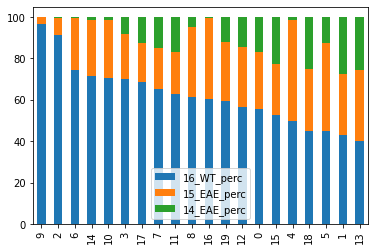

In [130]:
axis = sc_aggregate_test[[x+'_perc' for x in keys]].plot(kind="bar", stacked=True)
fig = axis.get_figure()


In [31]:
# Obtain phate data

#Tipycally t=23
data_phate = phate.PHATE().fit_transform(data_choroid)
data_phate = pd.DataFrame(data_phate, index=data_choroid.index)

Calculating PHATE...
  Running PHATE on 791 observations and 17684 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 3.56 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.44 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.14 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.72 seconds.
Calculated PHATE in 4.87 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

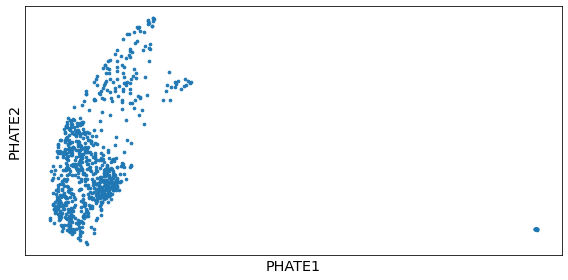

In [32]:
scprep.plot.scatter2d(data_phate, figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

## Differential expression

### Create sparse dataframe

In [33]:
data_sparse = scprep.utils.SparseDataFrame(data)

### Create differential expression dataframe for all clusters

In [34]:
# Create differential for all clusters

with tasklogger.log_task("t-test"):
    ttest_cluster_resutls = scprep.stats.differential_expression_by_cluster(data, 
                                                        kmeans_clusters, 
                                                        measure='ttest', 
                                                        direction='both',
                                                        gene_names=None, 
                                                        n_jobs=-2)
    
    ttest_df = pd.concat(ttest_cluster_resutls, axis=1).sum(axis=1, level=0)
ttest_df

Calculating t-test...
Calculated t-test in 497.18 seconds.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Tyrobp (ENSMUSG00000030579),-72.284598,856.733436,55.169561,-70.979376,142.692919,-64.885720,277.594605,-21.402547,16805.576035,55.213175,1012.094763,-60.247271,-64.077474,1.392977,599.473966,-66.647115,57.173176,-62.192684,3235.015623,9221.006481
Laptm5 (ENSMUSG00000028581),-70.568245,4322.200650,54.727326,-69.479519,14254.278128,-68.529993,85.336638,-13.936341,14749.519893,54.569153,856.818235,-71.121863,-62.819049,-19.164368,393.302404,-71.235407,71.605996,-57.887560,2077.377807,110.065460
Fcer1g (ENSMUSG00000058715),-68.267826,589.165657,56.902404,-68.204028,109.140304,-56.562621,452.646510,-44.587668,11663.469397,55.154459,-9.221001,-55.689931,-58.017920,96.601377,1458.934436,-68.373568,52.476410,-52.531956,1291.818425,14249.397304
C1qc (ENSMUSG00000036896),-65.978968,11934.534894,56.166805,-63.186326,-64.464954,-62.881585,58.576411,89.378877,6276.316566,60.857010,-60.480480,-56.868278,-60.987824,-40.625461,57.237539,-62.257897,65.606387,-46.357945,4185.126628,2946.372549
C1qb (ENSMUSG00000036905),-64.874654,10673.838065,55.841780,-61.284578,-61.513155,-61.035597,72.439233,25.656329,6292.304570,60.124907,-65.105929,-64.659742,-55.423624,-16.201280,139.113266,-63.684132,67.252471,-43.003663,7666.335231,4286.398240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fam181b (ENSMUSG00000051515),17678.998527,223.308422,1484.589935,887.763608,707.995404,547.878358,289.265394,7806.869681,687.999723,323.813641,339.891634,1346.795662,8960.669768,5851.894979,437.065809,11747.068263,318.001592,5398.261759,4452.902255,354.192747
Rnf215 (ENSMUSG00000003581),17679.998862,1702.132029,8807.854189,2108.394779,2942.960417,7013.830836,12277.450854,2900.565358,3869.405785,5904.304063,3190.692592,11774.464790,8927.319603,2206.905994,1003.191536,4155.052019,4194.876542,5801.299366,1736.114448,1898.127578
Dusp7 (ENSMUSG00000053716),17680.999003,13970.087514,2839.771412,2659.516197,5080.705378,8414.327900,4924.439350,2512.448451,13722.176153,3058.182211,7901.848243,7604.026014,530.505009,5981.964974,2820.038599,8316.480105,16157.430352,2921.854334,4339.518903,1071.036553
Abcb10 (ENSMUSG00000031974),17682.000270,10693.169108,14835.927013,13500.361648,7765.035140,6615.466737,9984.016115,1696.393647,16424.388666,16602.405723,13712.999779,14160.189195,15043.867719,4120.933788,1512.390112,9148.103651,14109.945837,10221.471534,8545.396628,4775.950112


In [35]:
# # Create differential for subset of clusters
# target_clusters = [6]
# diff_clusters = [1,3,5]

# result = diff_exp_clusters(target_clusters = target_clusters, 
#                            diff_clusters=diff_clusters, 
#                            clusters = kmeans_clusters, 
#                            data = data_sparse, 
#                            test_type = 'ttest', 
#                            direction = 'both')


# # Create differential for subset of clusters
# target_clusters = ['16_WT']
# diff_clusters = ['14_EAE', '15_EAE']

# result = diff_exp_clusters(target_clusters = target_clusters, 
#                            diff_clusters=diff_clusters, 
#                            clusters = metadata['sample_labels'], 
#                            data = data_sparse, 
#                            test_type = 'difference', 
#                            direction = 'both')

# Create differential for subset of clusters
target_cluster = '16_WT'
diff_clusters = ['14_EAE', '15_EAE']

# result = diff_exp_mul_clusters(target_clusters = target_clusters, 
#                            clusters = metadata['sample_labels'], 
#                            data = data_sparse, 
#                            test_type = 'difference', 
#                            direction = 'both')
result = diff_exp_one_target_to_many(target_subset = target_cluster, 
                                     diff_subsets=diff_clusters, 
                                     clusters = metadata['sample_labels'], 
                                     data = data_sparse, 
                                     test_type = 'difference', 
                                     direction = 'both')

result

Calculating diff_exp_target_diffs...
  Calculating Target vs everyone...
  Calculated Target vs everyone in 21.56 seconds.
  Calculating Target vs specific subset...
    Calculating cluster 14_EAE...
    Calculated cluster 14_EAE in 16.91 seconds.
    Calculating cluster 15_EAE...
    Calculated cluster 15_EAE in 18.24 seconds.
  Calculated Target vs specific subset in 35.16 seconds.
Calculated diff_exp_target_diffs in 56.72 seconds.


,16_WT,14_EAE,15_EAE
Cst3 (ENSMUSG00000027447),7.682580e+01,84.048781,71.904809
Cd74 (ENSMUSG00000024610),-2.149427e+01,-32.739578,-13.832878
Fth1 (ENSMUSG00000024661),-1.870705e+01,-14.729052,-21.417242
Fau (ENSMUSG00000038274),-9.821526e+00,-12.780048,-7.805893
Rps24 (ENSMUSG00000025290),-8.047410e+00,-11.331559,-5.809929
...,...,...,...
Gm26887 (ENSMUSG00000097120),3.957237e-06,-0.000841,0.000580
Ankub1 (ENSMUSG00000074591),3.261459e-06,0.006988,-0.004756
Piga (ENSMUSG00000031381),3.261459e-06,0.002181,-0.001480
Sept10 (ENSMUSG00000019917),1.869903e-06,0.001975,-0.001342


<AxesSubplot:title={'center':'Jund '}, ylabel='Jund (ENSMUSG00000071076)'>

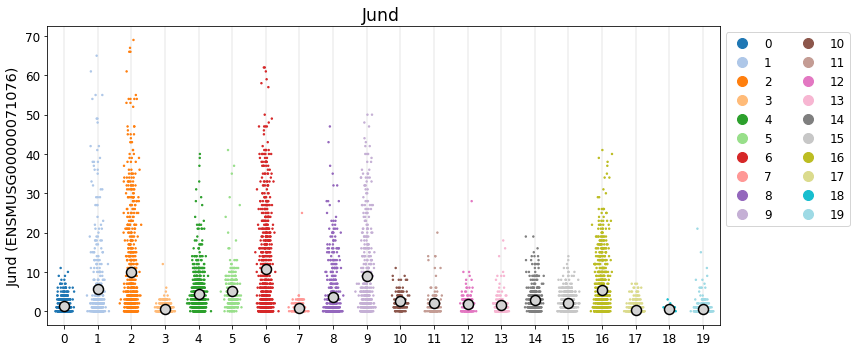

In [36]:
curr_gene = 'Jund '
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(kmeans_clusters, curr_expression, c=kmeans_clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)